In [159]:
# Import necessary libraries
import pandas as pd
import numpy as np
from colorama import Fore, Style
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.model_selection import cross_val_score, train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, mean_squared_error
from sklearn.inspection import permutation_importance
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


## Load Data & Select Valid Countries

In [160]:
# Load the data

data_path = os.path.join('..', 'raw_data', 'hotel_bookings_raw.csv')

df = pd.read_csv(data_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 43 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [132]:
#Drop columns
df = df.drop(columns=['arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'children', 'babies', 'previous_cancellations', 'previous_bookings_not_canceled', 'reserved_room_type', 'assigned_room_type', 'booking_changes', 'deposit_type', 'agent', 'days_in_waiting_list', 'customer_type', 'required_car_parking_spaces', 'total_of_special_requests', 'reservation_status_date', 'MO_YR'])
#Drop duplicates
df.drop_duplicates(inplace=True)
#Drop none
df.dropna(inplace=True)

In [133]:
valid_countries = ['PRT', 'GBR', 'ESP', 'FRA', 'DEU']

# Step 3: Filter the DataFrame to only include these valid countries
filtered_df = df[df['country'].isin(valid_countries)]

# Display the filtered DataFrame
# print(f"After removing countries appearing less than {country_threshold} times there are {len(filtered_df)} samples left")
print(f"There are still {len(filtered_df['country'].unique())} countries")
print(filtered_df['country'].unique())

There are still 5 countries
['PRT' 'GBR' 'ESP' 'FRA' 'DEU']


In [134]:
country_percentages = filtered_df['country'].value_counts(normalize=True) * 100

# Display the percentages
print(country_percentages)

country
PRT    45.420270
GBR    17.832893
FRA    15.115074
ESP    12.459796
DEU     9.171968
Name: proportion, dtype: float64


In [135]:
#Drop undefined

filtered_df = filtered_df[filtered_df["meal"] != "Undefined"]
filtered_df = filtered_df[filtered_df["market_segment"] != "Undefined"]
filtered_df = filtered_df[filtered_df["distribution_channel"] != "Undefined"]

print(f"After removing undefined values there are {len(filtered_df)} samples left")

After removing undefined values there are 55593 samples left


In [136]:
# Create the df that we will encode with to not change original data further
encoded_df = filtered_df.copy()

## Mapping & Encoding

In [137]:
#Change months to number
# Create a mapping of month names to numbers
month_mapping = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}
#Strip spaces
encoded_df['arrival_date_month'] = encoded_df['arrival_date_month'].str.strip()
# Replace month names with numbers
encoded_df['arrival_date_month'] = encoded_df['arrival_date_month'].map(month_mapping)

#Change hotel to binary
hotel_mapping = {
    'City Hotel': 1,
    'Resort Hotel': 0
}
#Strip spaces
encoded_df['hotel'] = encoded_df['hotel'].str.strip()
# Replace month names with numbers
encoded_df['hotel'] = encoded_df['hotel'].map(hotel_mapping)

In [138]:
# Change months to numbers
def encode_time(data, col, max_val):
    data[col +'_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

encoded_df = encode_time(encoded_df, 'arrival_date_month', 12)

In [139]:
encoded_df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'adr', 'reservation_status', 'CPI_AVG',
       'INFLATION', 'INFLATION_CHG', 'CSMR_SENT', 'UNRATE', 'INTRSRT', 'GDP',
       'FUEL_PRCS', 'CPI_HOTELS', 'US_GINI', 'DIS_INC',
       'arrival_date_month_sin', 'arrival_date_month_cos'],
      dtype='object')

In [140]:
# perform 1 hot encoding of categorical values
# One Hot Encode meal, country, market_segment, distribution_channel, reservation_status -> categorical (3-5 categories, encoden)
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Columns to one-hot encode
# can add 'country' here to use it as a predictor
columns_to_encode = ['meal', 'market_segment', 'distribution_channel', 'reservation_status', 'country']

# Instantiate the OneHotEncoder
ohe = OneHotEncoder(sparse_output=False, drop='first')  # drop='first' avoids the dummy variable trap

# Fit and transform the data
one_hot_encoded_data = ohe.fit_transform(encoded_df[columns_to_encode])

# Convert encoded data to DataFrame
one_hot_df = pd.DataFrame(one_hot_encoded_data, columns=ohe.get_feature_names_out(columns_to_encode))

# Concatenate the encoded columns with the original DataFrame
encoded_df = pd.concat([encoded_df.reset_index(drop=True), one_hot_df.reset_index(drop=True)], axis=1)

# Drop the original columns that were encoded
encoded_df.drop(columns=columns_to_encode, inplace=True)

# Display the first few rows of the updated DataFrame
print(one_hot_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55593 entries, 0 to 55592
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   meal_FB                       55593 non-null  float64
 1   meal_HB                       55593 non-null  float64
 2   meal_SC                       55593 non-null  float64
 3   market_segment_Complementary  55593 non-null  float64
 4   market_segment_Corporate      55593 non-null  float64
 5   market_segment_Direct         55593 non-null  float64
 6   market_segment_Groups         55593 non-null  float64
 7   market_segment_Offline TA/TO  55593 non-null  float64
 8   market_segment_Online TA      55593 non-null  float64
 9   distribution_channel_Direct   55593 non-null  float64
 10  distribution_channel_GDS      55593 non-null  float64
 11  distribution_channel_TA/TO    55593 non-null  float64
 12  reservation_status_Check-Out  55593 non-null  float64
 13  r

In [141]:
# Robust Scaler
from sklearn.preprocessing import RobustScaler

features_to_robust = ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'adr', 'FUEL_PRCS']
robust_scaler = RobustScaler()
robust_scaler.fit(encoded_df[features_to_robust])
encoded_df[features_to_robust] = robust_scaler.transform(encoded_df[features_to_robust])
encoded_df.head()

,hotel,is_canceled,lead_time,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,is_repeated_guest,adr,CPI_AVG,...,market_segment_Online TA,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,reservation_status_Check-Out,reservation_status_No-Show,country_ESP,country_FRA,country_GBR,country_PRT
0,0,0,2.684685,7,-0.5,-0.666667,0.0,0,-1.484375,238.034,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0,0,6.243243,7,-0.5,-0.666667,0.0,0,-1.484375,238.034,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0,0,-0.333333,7,-0.5,-0.333333,-1.0,0,-0.312500,238.034,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0,0,-0.279279,7,-0.5,-0.333333,-1.0,0,-0.312500,238.034,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0,0,-0.270270,7,-0.5,0.000000,0.0,0,0.046875,238.034,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0


In [142]:
from sklearn.preprocessing import MinMaxScaler

features_to_minmax = ['CPI_AVG', 'INFLATION', 'INFLATION_CHG', 'CSMR_SENT', 'UNRATE', 'INTRSRT', 'GDP', 'DIS_INC', 'CPI_HOTELS']
minmax_scaler = MinMaxScaler()
minmax_scaler.fit(encoded_df[features_to_minmax])
encoded_df[features_to_minmax] = minmax_scaler.transform(encoded_df[features_to_minmax])
encoded_df.head()

,hotel,is_canceled,lead_time,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,is_repeated_guest,adr,CPI_AVG,...,market_segment_Online TA,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,reservation_status_Check-Out,reservation_status_No-Show,country_ESP,country_FRA,country_GBR,country_PRT
0,0,0,2.684685,7,-0.5,-0.666667,0.0,0,-1.484375,0.281229,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0,0,6.243243,7,-0.5,-0.666667,0.0,0,-1.484375,0.281229,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0,0,-0.333333,7,-0.5,-0.333333,-1.0,0,-0.312500,0.281229,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0,0,-0.279279,7,-0.5,-0.333333,-1.0,0,-0.312500,0.281229,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0,0,-0.270270,7,-0.5,0.000000,0.0,0,0.046875,0.281229,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0


In [163]:
#total stays
encoded_df['total_stays'] = encoded_df['stays_in_weekend_nights'] + encoded_df['stays_in_week_nights']
encoded_df['total_stays']
encoded_df = encoded_df.drop(columns=["stays_in_weekend_nights", "stays_in_week_nights"])


## Model Selection & Training

In [144]:
country_variables = []
for c in encoded_df.columns:
    if "country" in c:
        country_variables.append(c)

In [162]:
# Assuming df_encoded is your DataFrame and adr is the target variable
target_variable = 'is_canceled'
predictors = [*country_variables, 'FUEL_PRCS', 'lead_time', 'adr', 'arrival_date_month_sin','arrival_date_month_cos', 'total_stays', 'INFLATION']


#if this doesnt work, label encode country first
X = encoded_df[predictors]
y =encoded_df[target_variable]


In [146]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [147]:
# Train a RandomForestRegressor
estimators = [("RandomForrest", RandomForestClassifier(random_state=42)), ("GradientBoost", GradientBoostingClassifier(random_state=42))]
model = StackingClassifier(estimators=estimators)
model.fit(X_train, y_train)


StackingClassifier(estimators=[('RandomForrest',
                                RandomForestClassifier(random_state=42)),
                               ('GradientBoost',
                                GradientBoostingClassifier(random_state=42))])

In [148]:
## test different models
# import matplotlib.pyplot as plt
# import numpy as np
# from matplotlib.colors import ListedColormap

# from sklearn.datasets import make_circles, make_classification, make_moons
# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
# from sklearn.gaussian_process import GaussianProcessClassifier
# from sklearn.gaussian_process.kernels import RBF
# from sklearn.inspection import DecisionBoundaryDisplay
# from sklearn.model_selection import train_test_split
# from sklearn.naive_bayes import GaussianNB
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.neural_network import MLPClassifier
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.svm import SVC
# from sklearn.tree import DecisionTreeClassifier

# names = [
#     "Nearest Neighbors",
#    # "Linear SVM",
#    # "RBF SVM",
#    # "Gaussian Process",
#     "Decision Tree",
#     "Random Forest",
#     "Neural Net",
#     "AdaBoost",
#     "Naive Bayes",
#     "QDA",
# ]

# classifiers = [
#     KNeighborsClassifier(3),
#     #SVC(kernel="linear", C=0.025, random_state=42),
#    #SVC(gamma=2, C=1, random_state=42),
#    # GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
#     DecisionTreeClassifier(max_depth=5, random_state=42),
#     RandomForestClassifier(
#         max_depth=5, n_estimators=10, max_features=1, random_state=42
#     ),
#     MLPClassifier(alpha=1, max_iter=1000, random_state=42),
#     AdaBoostClassifier(algorithm="SAMME", random_state=42),
#     GaussianNB(),
#     QuadraticDiscriminantAnalysis(),
# ]

# scores = []
# for name, clf in zip(names, classifiers):
#     clf.fit(X_train, y_train)
#     score = clf.score(X_val, y_val)
#     scores.append((name, score))


# scores

In [149]:
#cross val
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
y_pred = model.predict(X_val)
precision = precision_score(y_val, y_pred, average='weighted')
rec = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')
print(precision, rec, f1, cv_scores.mean())


#with RandomForrest + GradientBoost stack: 0.8801700322011814 0.8815064643057897 0.8779045882099347 0.8809691738194925


0.8860990312041876 0.8867903316469927 0.8831270300895177 0.8879957985666301


In [158]:
from demand_predictor.ml_logic.registry import save_model
save_model(model)

✅ Model saved locally at /Users/mila/code/sarahfink123/demand_prediction/demand_predictor/../training_outputs/models/20240531-152522.pkl


In [150]:
# # Get feature importances
# importances = model.feature_importances_

# # Create a DataFrame for visualization
# feature_importance_df = pd.DataFrame({
#     'Feature': X.columns,
#     'Importance': importances
# })

# # Sort by importance
# feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# # Plot the feature importances
# plt.figure(figsize=(10, 8))
# sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
# plt.title('Feature Importance')
# plt.show()

AttributeError: 'StackingClassifier' object has no attribute 'feature_importances_'

0.987287753621896 0.9872860515443636 0.9872741960483408 0.6226636375858824


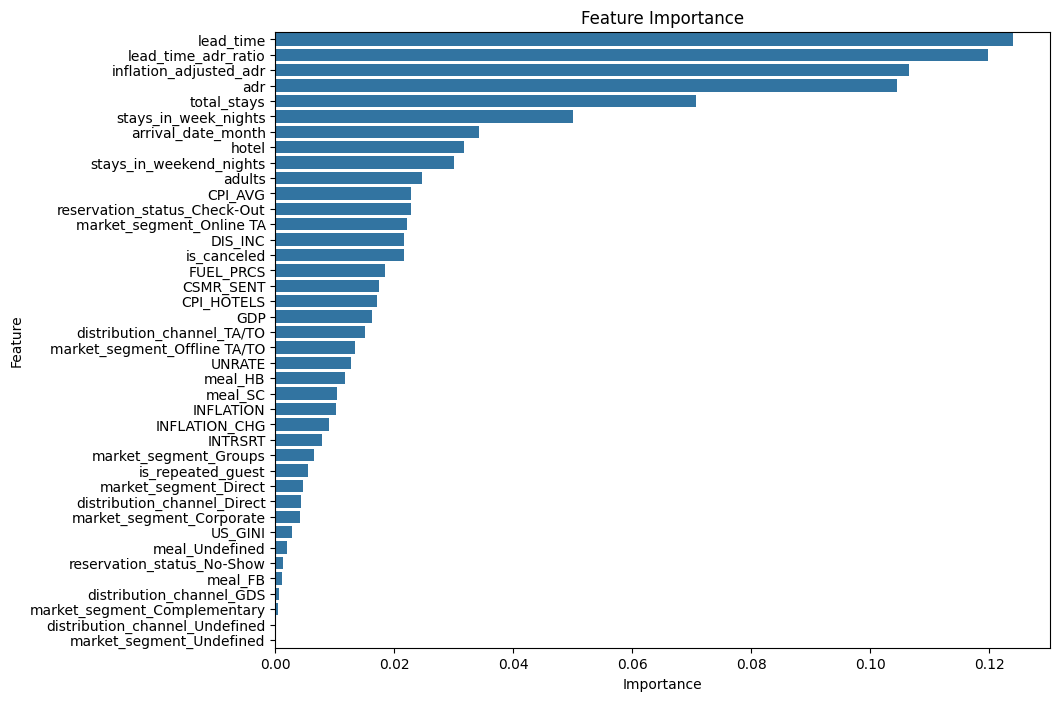

In [ ]:

# # Make predictions on the test set
# y_pred = model.predict(X_test)
# precision = precision_score(X_val, y_val, average='weighted')
# rec = recall_score(y_val, y_pred, average='weighted')
# f1 = f1_score(y_train, y_pred, average='weighted')
# print(precision, rec, f1, cv_scores.mean())
